In [1]:
import os
import re
import ase
from ase.visualize import view

import ml_collections
import tensorflow as tf
import matplotlib.pyplot as plt

from molnet.data import augmentation, input_pipeline_water
from configs import root_dirs
from configs.tests import water_test

from typing import Any, Dict, List, Tuple, Sequence, Optional

2025-01-30 11:22:23.517446: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 11:22:23.519008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 11:22:23.546761: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 11:22:23.547532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 11:22:26.786874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
dataset = "water-bilayer-tf"

config = water_test.get_config()
config.root_dir = root_dirs.get_root_dir(dataset)

config.train_molecules = (0, 8000)
config.val_molecules = (8000, 12000)

config.target_z_cutoff = 1.5
config.z_cutoff = 1.5
config.interpolate_input_z = None

In [3]:
ds = input_pipeline_water.get_datasets(config)['val']

2025-01-30 11:22:35.974955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-30 11:22:36.015567: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_pr

In [4]:
batch = next(ds)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 9542058055893189865
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16173093342415224832
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

In [5]:
for k, v in batch.items():
    print(k, v.shape)

images (16, 128, 128, 15, 1)
atom_map (16, 128, 128, 15, 2)
xyz (16, 500, 5)
sw (16, 2, 3)


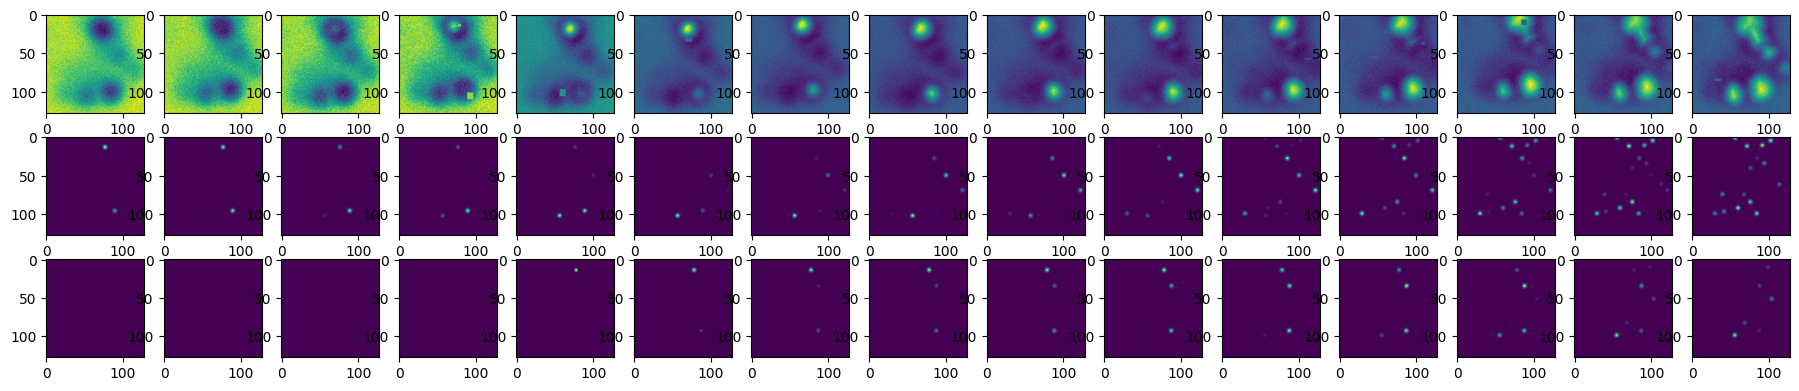

In [6]:
num_species = batch["atom_map"].shape[-1]
num_heights = batch["atom_map"].shape[-2]
index = 7

fig = plt.figure(figsize=(num_heights*1.5, (1+num_species)*1.5))
for i in range(num_heights):
    ax = plt.subplot(num_species+1, num_heights, i + 1)
    ax.imshow(batch["images"][index, :, :, i, 0])

    ax = plt.subplot(num_species+1, num_heights, num_heights + i + 1)
    ax.imshow(batch["atom_map"][index, :, :, i, 0])

    ax = plt.subplot(num_species+1, num_heights, 2*num_heights + i + 1)
    ax.imshow(batch["atom_map"][index, :, :, i, 1])

xyz = batch["xyz"][index]
xyz = xyz[xyz[:, -1] > 0]
mol = ase.Atoms(
    positions=xyz[:, :3],
    numbers=xyz[:, -1].astype(int),
)

#view(mol)

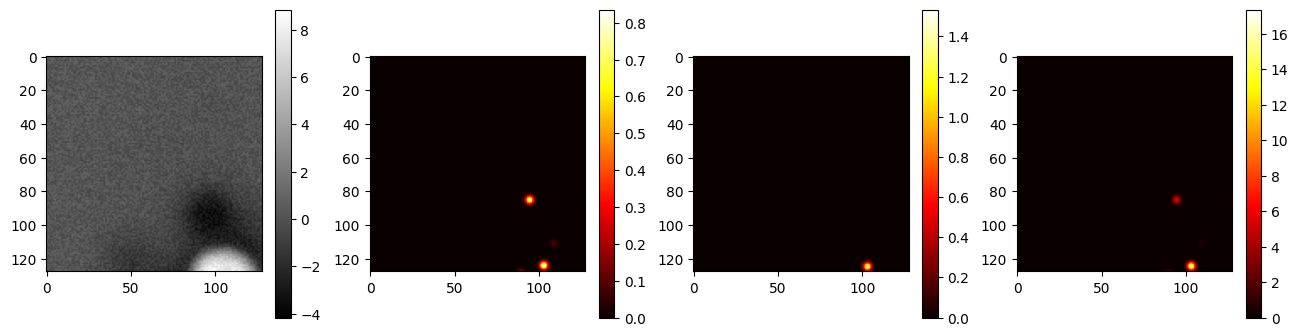

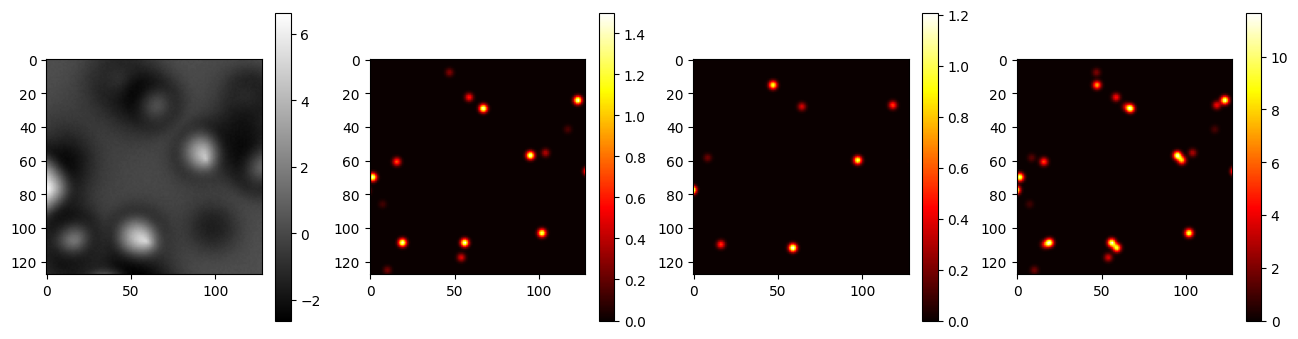

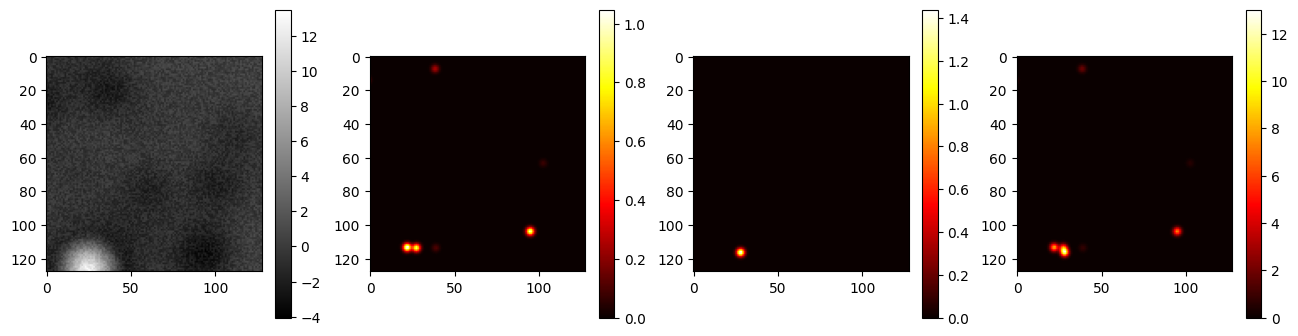

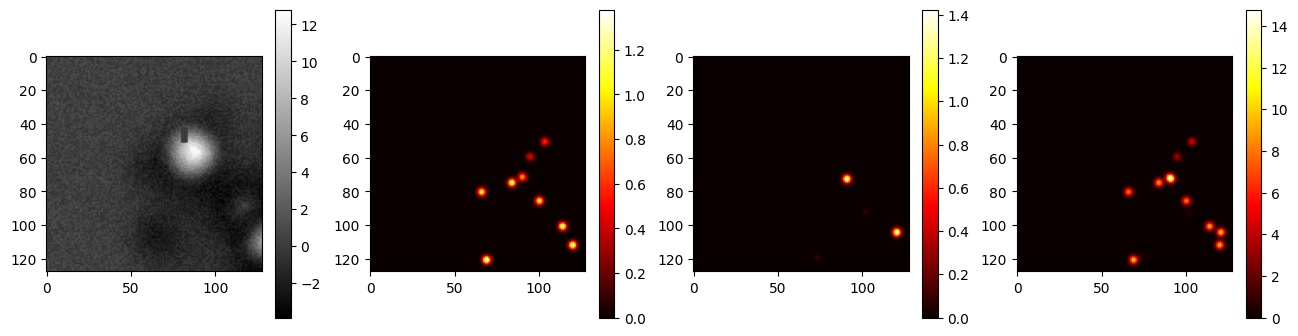

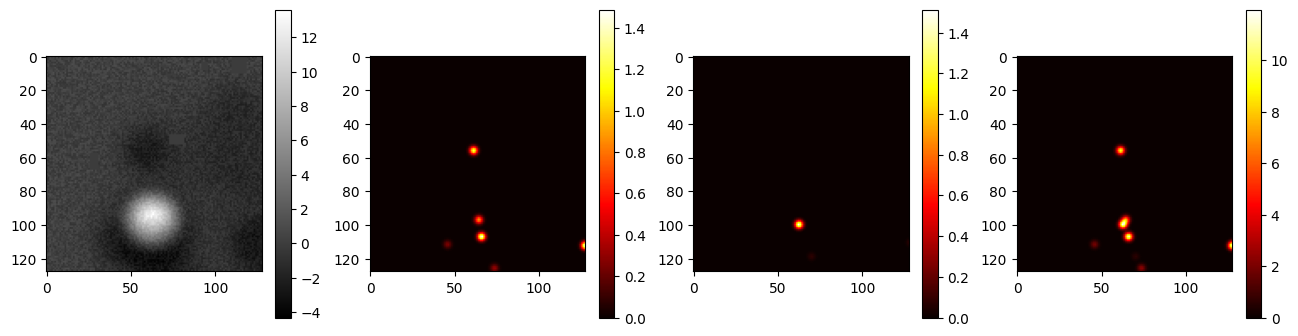

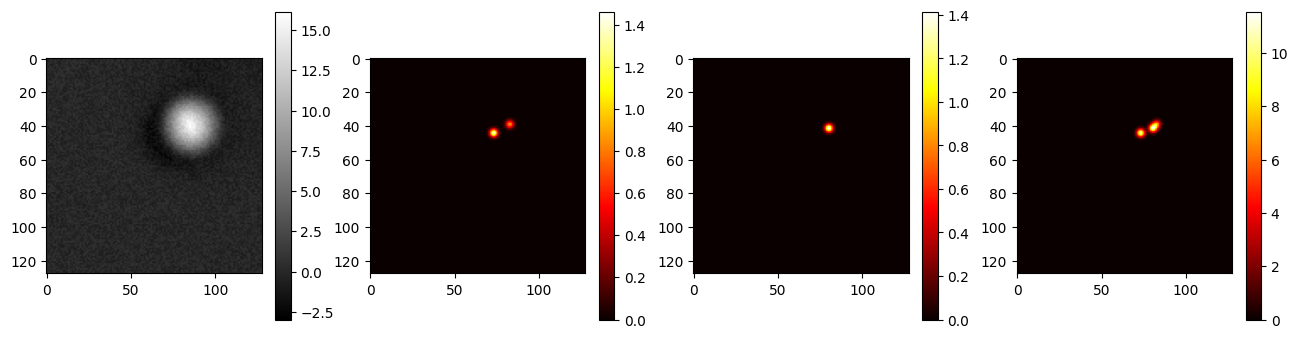

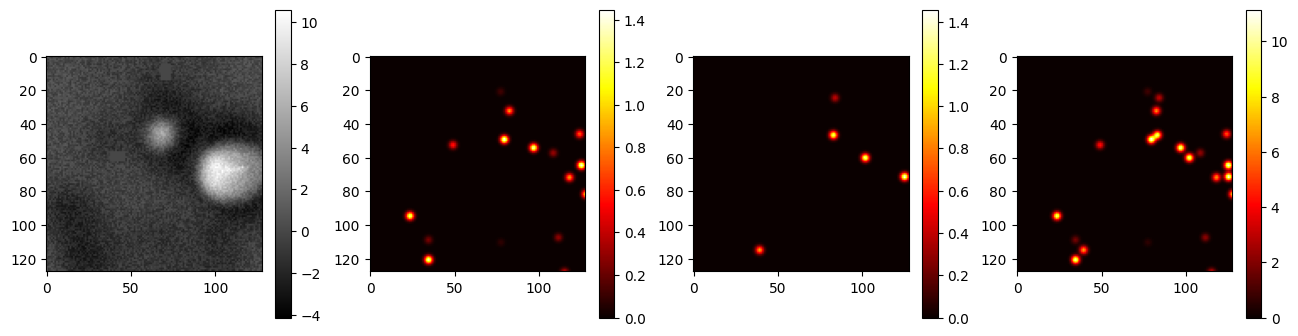

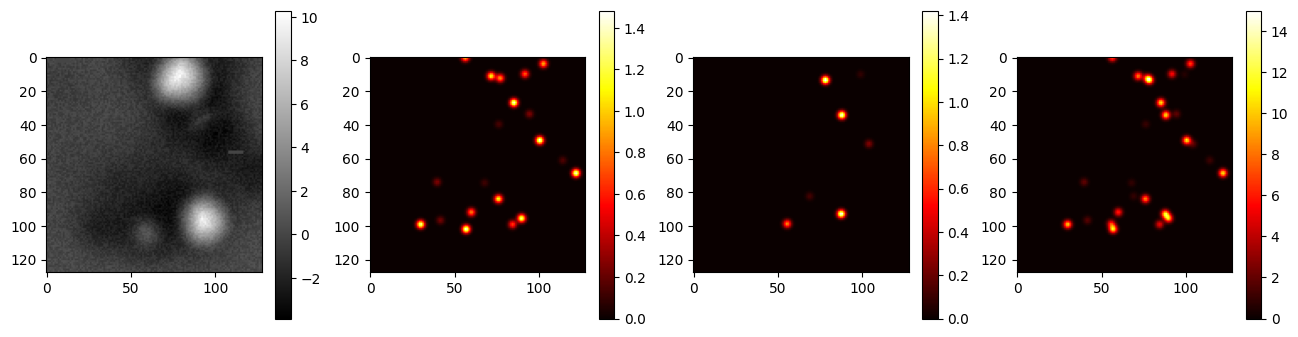

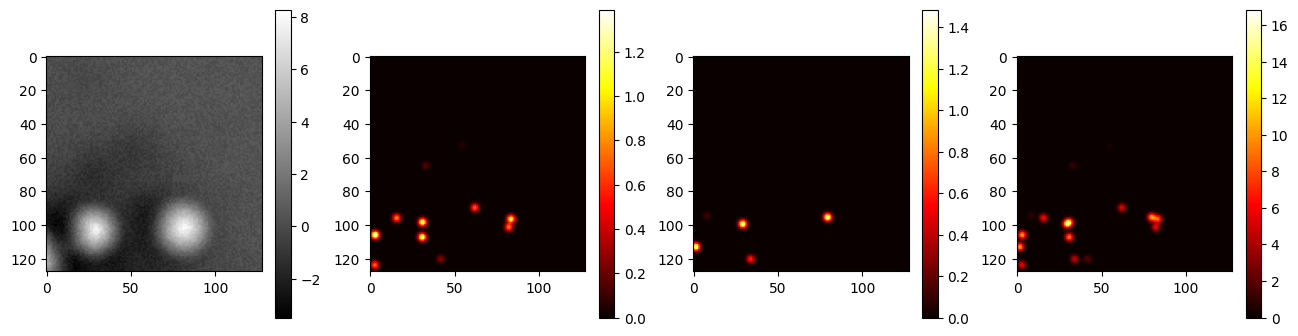

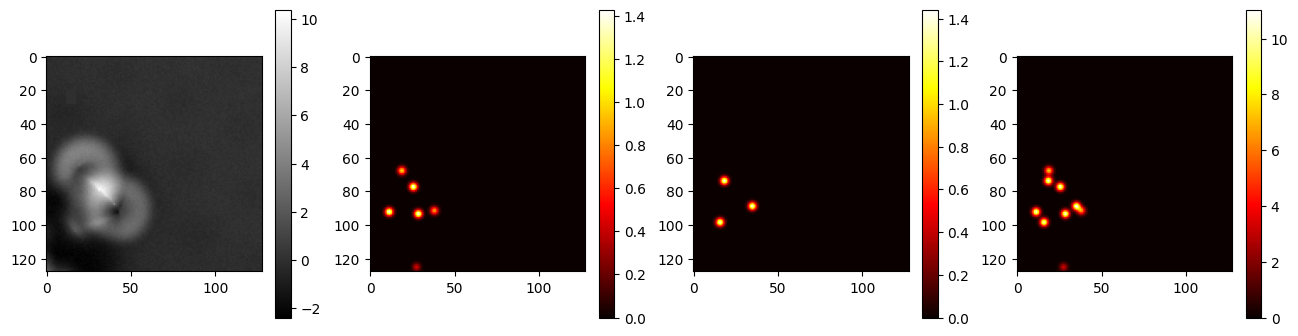

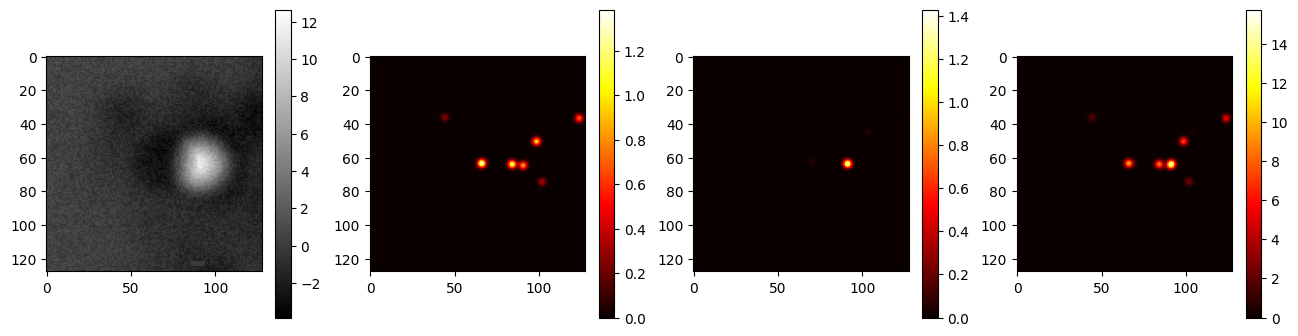

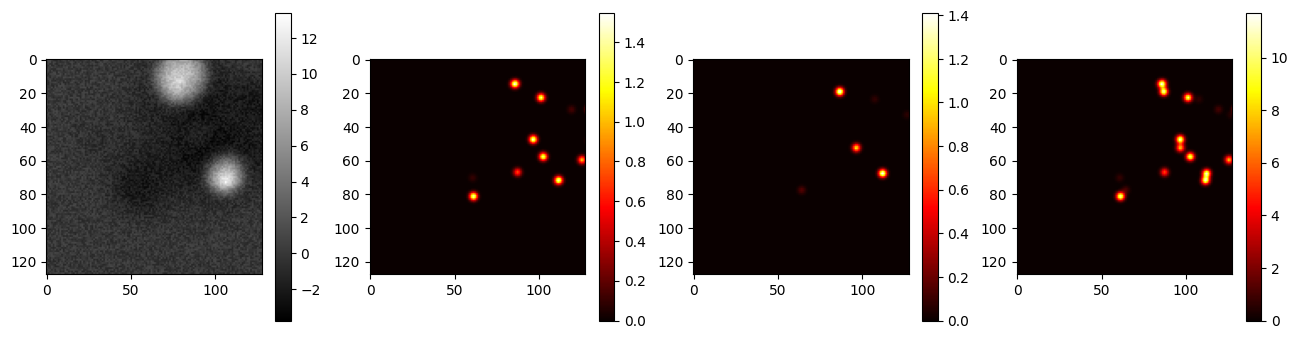

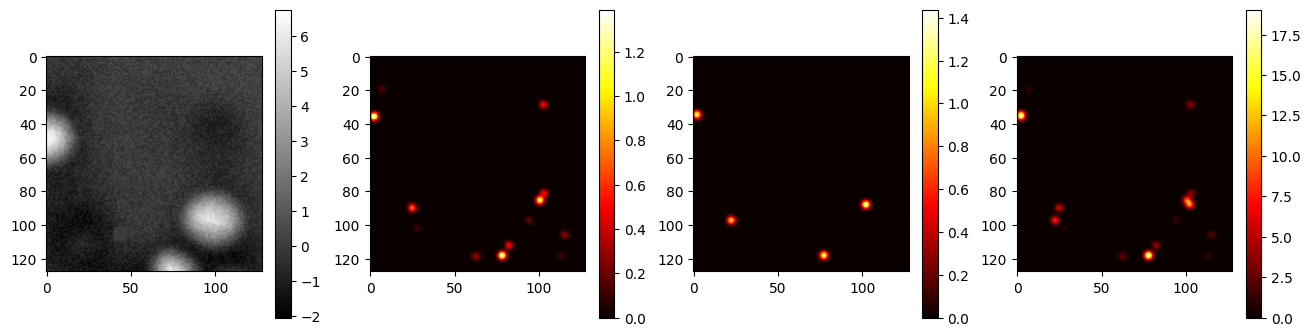

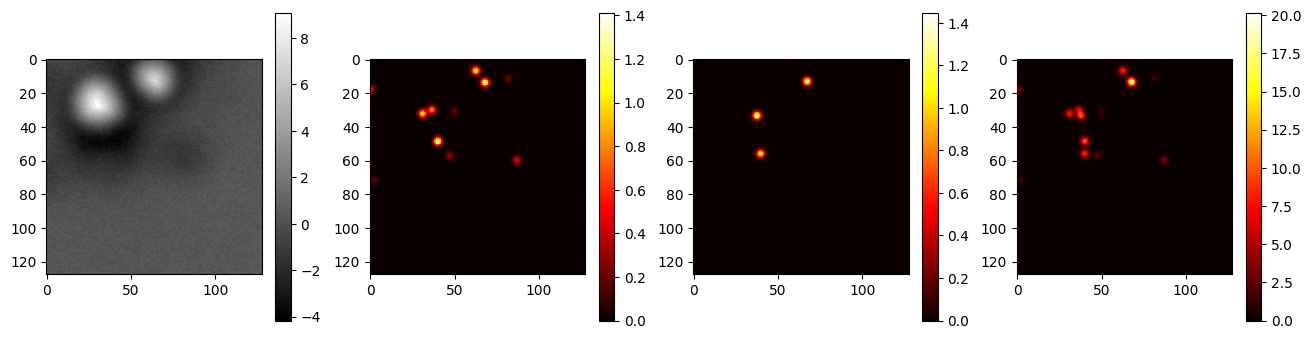

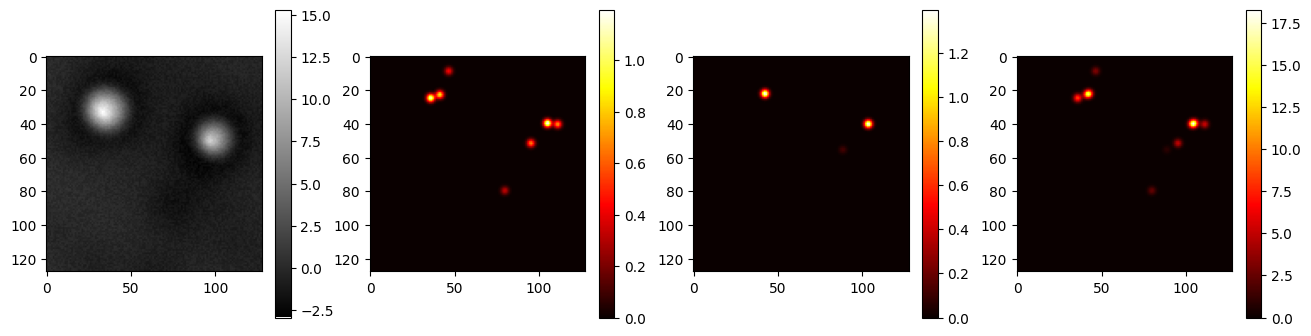

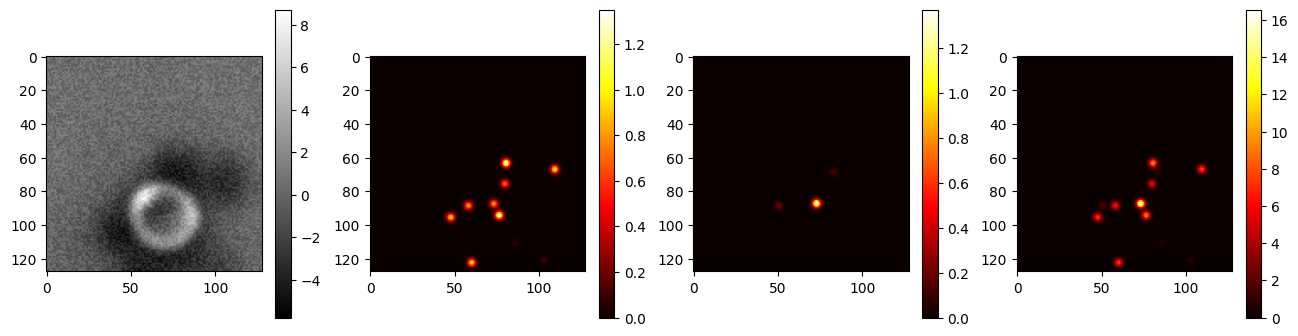

In [7]:
x = batch["images"]
y = batch["atom_map"]

for i in range(x.shape[0]):
    fig = plt.figure(figsize=(16, 4))
    ax = plt.subplot(141)
    im = ax.imshow(x[i, ..., -5, 0], cmap='gray')
    plt.colorbar(im)

    ax = plt.subplot(142)
    im = ax.imshow(y[i, ..., 0].mean(axis=-1), cmap='hot')
    plt.colorbar(im)

    ax = plt.subplot(143)
    im = ax.imshow(y[i, ..., 1].mean(axis=-1), cmap='hot')
    plt.colorbar(im)

    ax = plt.subplot(144)
    im = ax.imshow(y[i].mean(axis=-1).sum(axis=-1), cmap='hot')
    plt.colorbar(im)

    plt.show()

## Changes to the pipeline can be tested here easily

In [15]:
def get_datasets(
    config: ml_collections.ConfigDict,
) -> Dict[str, tf.data.Dataset]:
    """Loads datasets for each split."""

    filenames = sorted(os.listdir(config.root_dir))
    filenames = [
        os.path.join(config.root_dir, f)
        for f in filenames
        if f.startswith("afms_")
    ]

    if len(filenames) == 0:
        raise ValueError(f"No files found in {config.root_dir}.")
    
    # Partition the filenames into train, val, and test.
    def filter_by_molecule_number(
        filenames: Sequence[str], start: int, end: int
    ) -> List[str]:
        def filter_file(filename: str, start: int, end: int) -> bool:
            filename = os.path.basename(filename)
            file_start, file_end = [int(val) for val in re.findall(r"\d+", filename)]
            return start <= file_start and file_end <= end

        return [f for f in filenames if filter_file(f, start, end)]

    # Number of molecules for training can be smaller than the chunk size.
    files_by_split = {
        "train": filter_by_molecule_number(filenames, *config.train_molecules),
        "val": filter_by_molecule_number(filenames, *config.val_molecules),
    }

    element_spec = tf.data.Dataset.load(filenames[0]).element_spec
    datasets = {}
    for split, files_split in files_by_split.items():

        # Load the files.
        dataset_split = tf.data.Dataset.from_tensor_slices(files_split)
        # Shuffle the files.
        dataset_split = dataset_split.shuffle(1000)
        dataset_split = dataset_split.interleave(
            lambda path: tf.data.Dataset.load(path, element_spec=element_spec),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )

        # Repeat the dataset.
        dataset_split = dataset_split.repeat()

        # Shuffle the dataset.
        if split == 'train':
            dataset_split = dataset_split.shuffle(
                1000,
                reshuffle_each_iteration=True,
            )

        # batches consist of a dict {'x': image, 'xyz': xyz, 'sw': scan window})
        dataset_split = dataset_split.map(
            lambda x: {
                "images": x["x"],
                "xyz": x["xyz"],
                "sw": x["sw"],
            },
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )

        # Preprocess images.
        dataset_split = dataset_split.map(
            lambda x: _preprocess_batch(
                x,
                interpolate_z=config.interpolate_input_z,
                z_cutoff=config.z_cutoff,
            ),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )

        dataset_split = dataset_split.map(
            lambda x: _compute_atom_maps(
                x,
                z_cutoff=config.target_z_cutoff,
                sigma=config.sigma,
                factor=config.gaussian_factor,
                dataset=config.dataset 
            ),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True
        )

        # Crop images and atom maps.
        dataset_split = dataset_split.map(
            lambda x: _augment_image_and_atom_map(
                x,
                crop_size=128, # TODO: Make this a parameter in the config.
                cutout_probs=config.cutout_probs,
                noise_std=config.noise_std,
                max_shift_per_slice=config.max_shift_per_slice,
            ),
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )

        # Batch the dataset.
        dataset_split = dataset_split.batch(config.batch_size)
        dataset_split = dataset_split.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
        
        datasets[split] = dataset_split
    return datasets


def _preprocess_batch(
    batch: Dict[str, tf.Tensor],
    interpolate_z: Optional[int] = None,
    z_cutoff: float = 1.0,
) -> Dict[str, tf.Tensor]:
    """Preprocesses images."""
    
    x = batch["images"]
    x = tf.transpose(x, perm=[1, 0, 2])
    x = x[::-1, :, :]

    sw = batch["sw"]

    # Pad the xyz coordinates.
    xyz = batch["xyz"]
    n_atoms = tf.shape(xyz)[0]
    pad = 500 - n_atoms
    xyz = tf.pad(xyz, [[0, pad], [0, 0]])

    # Shift xyz coordinates by scan window, so that scan window starts at (0, 0).
    #shifted_xyz = xyz[:, :2] - sw[0, :2]
    #shifted_xyz = tf.concat([shifted_xyz, xyz[:, 2:]], axis=-1)

    # Also shift the scan window to start at (0, 0).
    #shifted_sw = sw - sw[0]

    # Crop slices to z_cutoff.
    z_slices = z_cutoff / 0.1
    x = x[..., -int(z_slices):]


    # Add channel dimension.
    x = x[..., tf.newaxis]

    # Interpolate to `interpolate_z` z slices
    if interpolate_z is not None:
        x = tf.image.resize(x, (x.shape[1], interpolate_z), method='bilinear')

    sample = {
        "images": x,
        "xyz": xyz,
        "sw": sw,
    }
    
    return sample


def _compute_atom_maps(
    batch: Dict[str, tf.Tensor],
    z_cutoff: float = 1.0,
    sigma: float = 0.2,
    factor: float = 5.0,
    dataset: str = None,
) -> tf.Tensor:
    """Computes atom maps."""
    xyz = batch["xyz"]
    z_max = tf.reduce_max(xyz[:, 2])
    sw = batch["sw"]
    xres = batch["images"].shape[0]

    # Compute grids # TODO: REPLACE WITH COORDINATES FROM BATCH["sw"]
    # Tried, didn't work. Come back to this later.
    # For now, the molecule (and scan window) is shifted in _preprocess_images to start at (0, 0).
    #x = tf.linspace(0., 32., 256)
    #y = tf.linspace(0., 32., 256)
    x = tf.linspace(sw[0,0], sw[1,0], xres)
    y = tf.linspace(sw[0,1], sw[1,1], xres)
    z_steps = tf.cast(z_cutoff / 0.1, tf.int32)
    #z = tf.linspace(z_max-z_cutoff, z_max, z_steps)

    # Reversing the z axis seems to be essential for smooth learning.
    z = tf.linspace(z_max, z_max-z_cutoff, z_steps)

    X, Y, Z = tf.meshgrid(x, y, z, indexing='xy')

    # Compute atom maps.
    maps_h = tf.zeros_like(X)
    maps_o = tf.zeros_like(X)

    for atom in xyz:
        # Skip atoms that are not in the z_cutoff range.
        if atom[2] < z_max - z_cutoff - 2*sigma:
            continue

        # Skip padding atoms
        if atom[-1] == 0:
            continue

        m = tf.exp(
            -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
        )
        
        # all values below 1e-4 to 0
        m = tf.where(m < 1e-2, tf.zeros_like(m), m*factor)

        if atom[-1] == 1:
            maps_h += m
        elif atom[-1] == 8:
            maps_o += m

    atom_map = tf.stack([maps_h, maps_o], axis=0)
    atom_map = tf.transpose(atom_map, perm=[1, 2, 3, 0])

    return {
        "images": batch["images"],
        "xyz": batch["xyz"],
        "sw": batch["sw"],
        "atom_map": atom_map,
    }

def _augment_image_and_atom_map(
    batch: Dict[str, tf.Tensor],
    crop_size: int,
    cutout_probs: List[float],
    noise_std: float,
    max_shift_per_slice: float,
) -> Dict[str, tf.Tensor]:
    """Crops images and atom maps."""
    x = batch["images"]
    y = batch["atom_map"]
    xyz = batch["xyz"]

    # Normalize the images.
    x = augmentation.normalize_images(x)

    # Random rotation
    x, y = augmentation.random_rotate_image_and_atom_map(x, y)

    # Randomly shift the slices.
    x = augmentation.random_slice_shift(x, max_shift_per_slice=max_shift_per_slice)

    # Crop the images and atom maps.
    #x, y = augmentation.random_crop_on_top_atom(x, y, xyz, shift=20, crop_size=crop_size)
    x, y = center_crop(x, y, size=crop_size, shift=10)

    # Add noise to the images.
    x = augmentation.add_noise(x, noise_std)

    # Create cutouts.
    x = augmentation.add_random_cutouts(
        x, cutout_probs=cutout_probs, cutout_size_range=(2, 10), image_size=crop_size
    )

    return {
        "images": x,
        "atom_map": y,
        "xyz": batch["xyz"],
        "sw": batch["sw"],
    }


In [16]:
def center_crop(x, y, size, shift):
    """
    Center-crops a stack of 2D images to the specified size.

    Args:
        x (tf.Tensor): A 4D tensor of shape (X, Y, Z, channels).
        size (int): The size of the crop.

    Returns:
        tf.Tensor: The center-cropped images.
    """

    # Compute the crop size
    crop_size = tf.constant([size, size])

    # Compute the starting point of the crop
    start = (tf.shape(x)[:2] - crop_size) // 2

    # Crop the images
    x = x[start[0]:start[0] + crop_size[0], start[1]:start[1] + crop_size[1]]

    return x, y


In [17]:
datasets = get_datasets(config)
batch = next(datasets['val'])

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 12320820874903670224
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 9513306213227736330
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

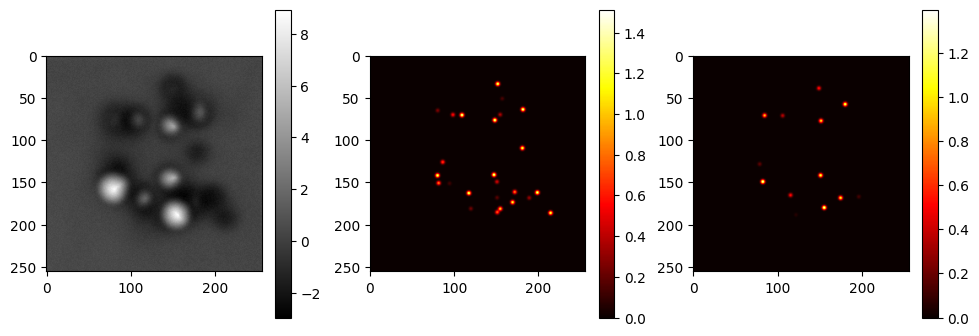

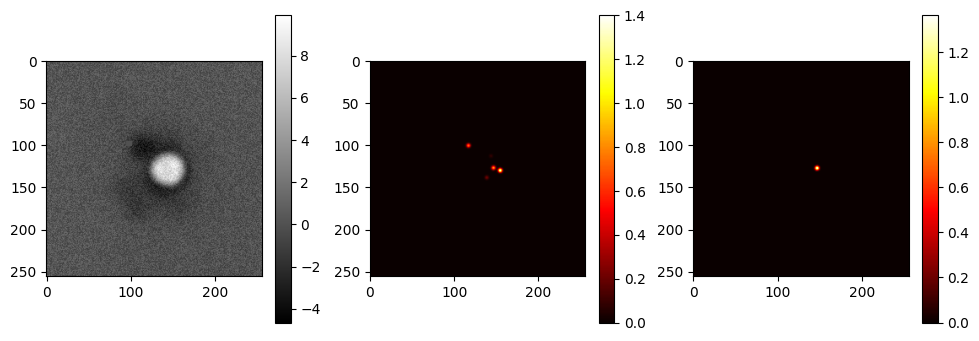

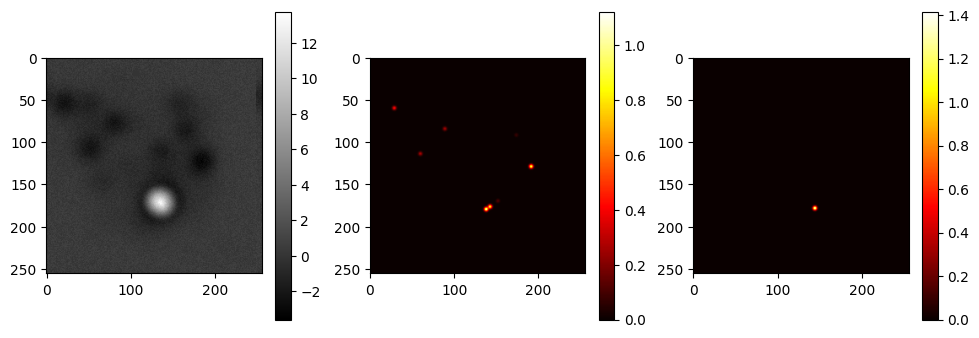

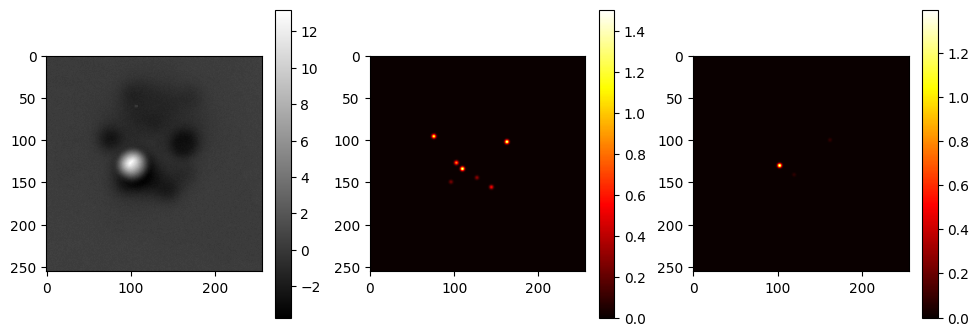

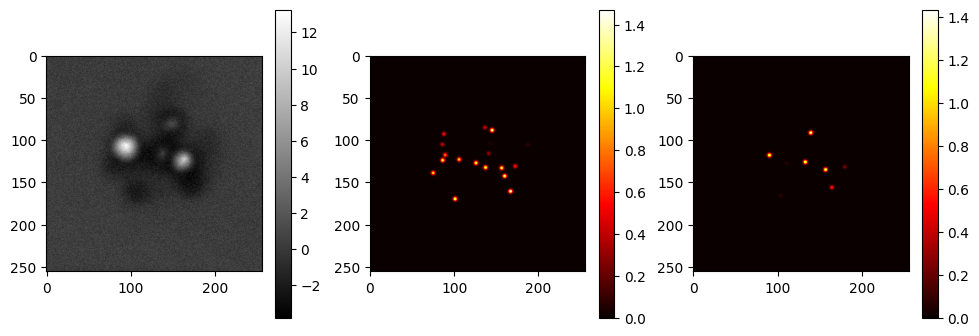

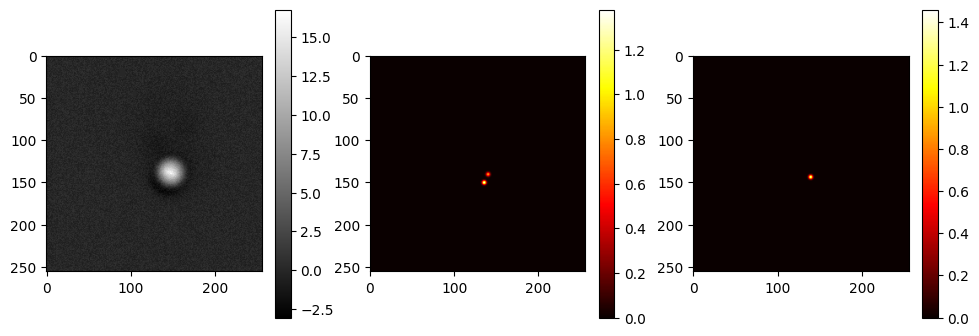

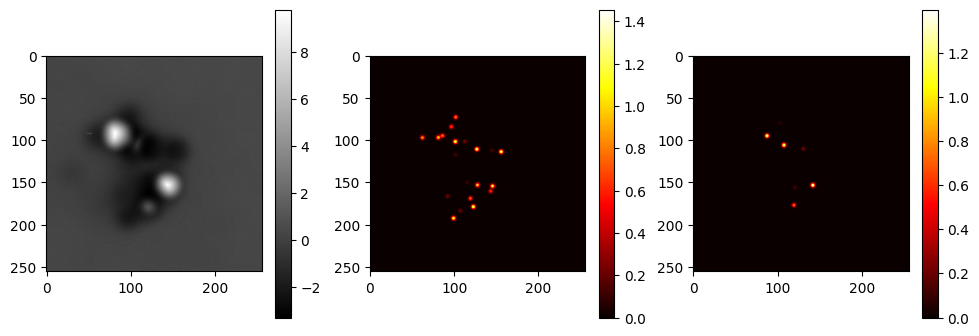

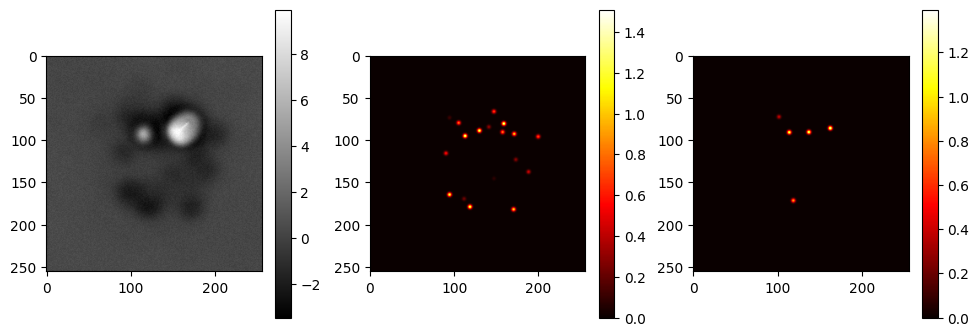

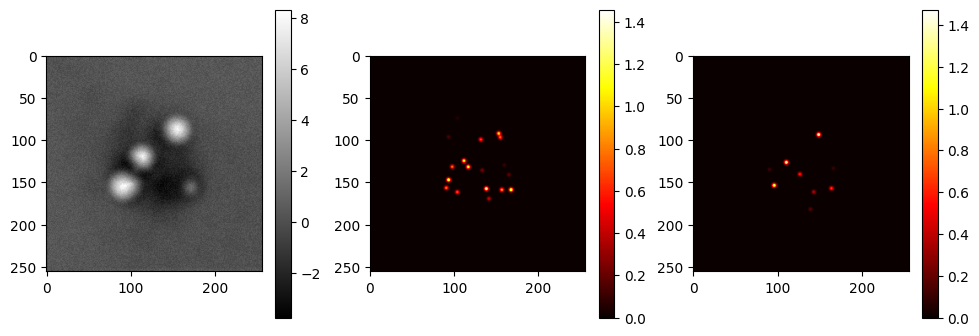

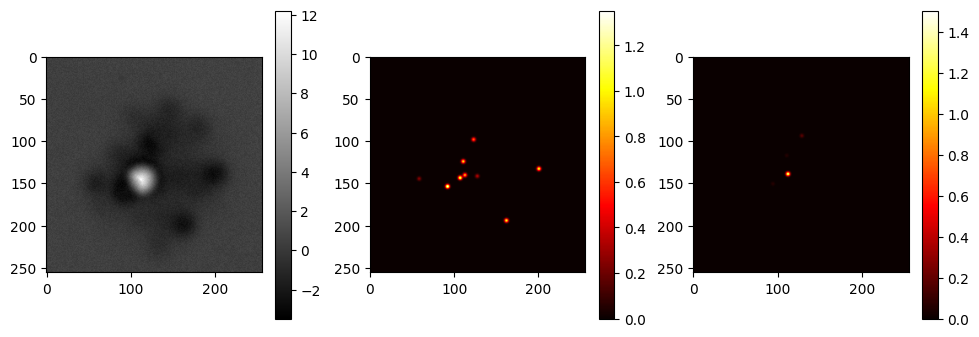

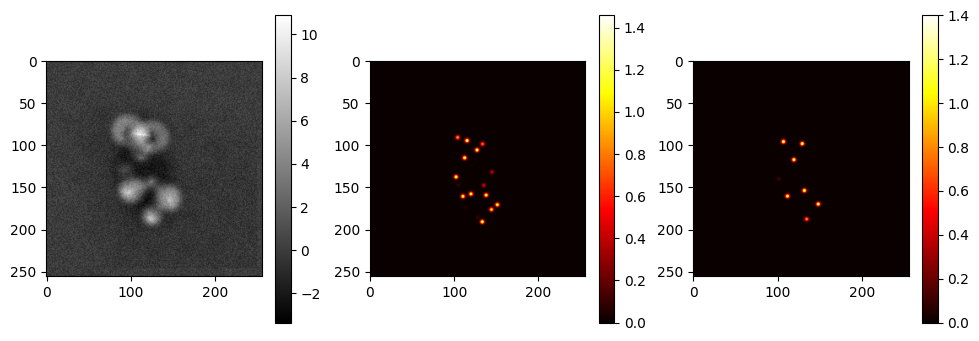

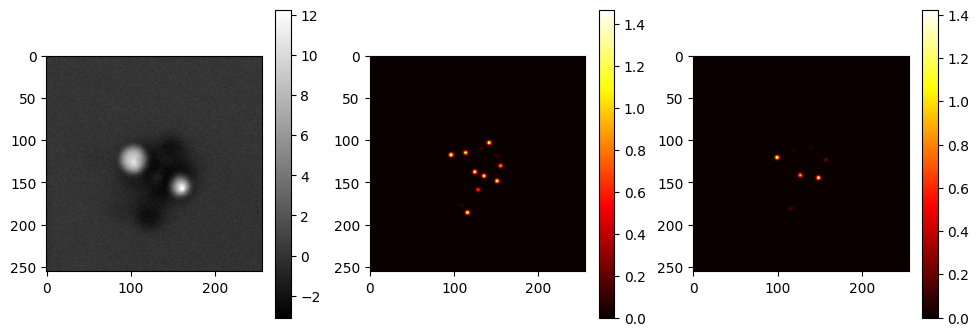

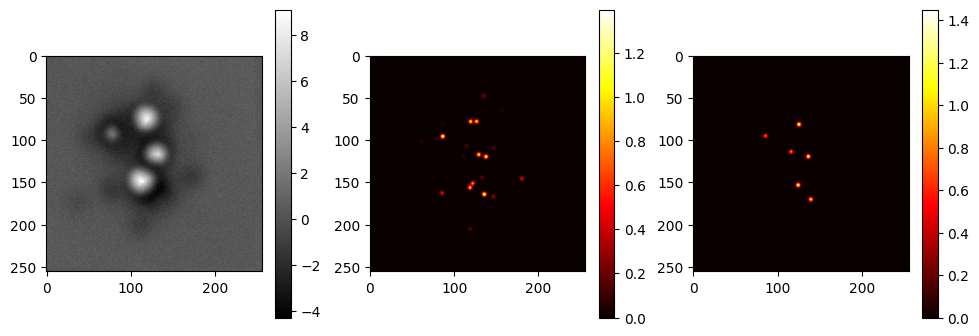

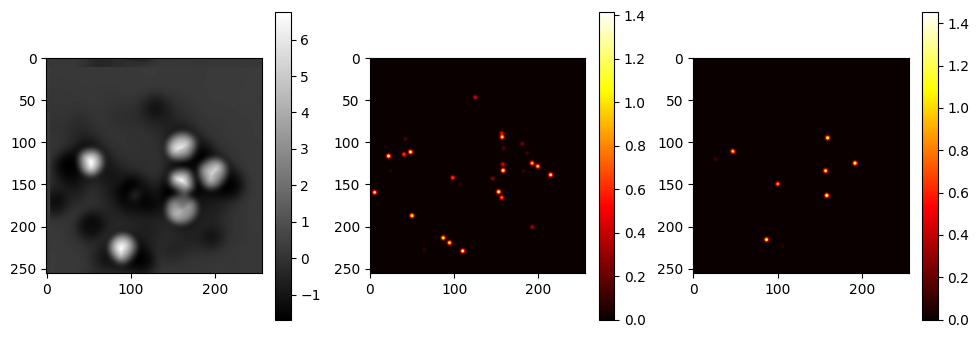

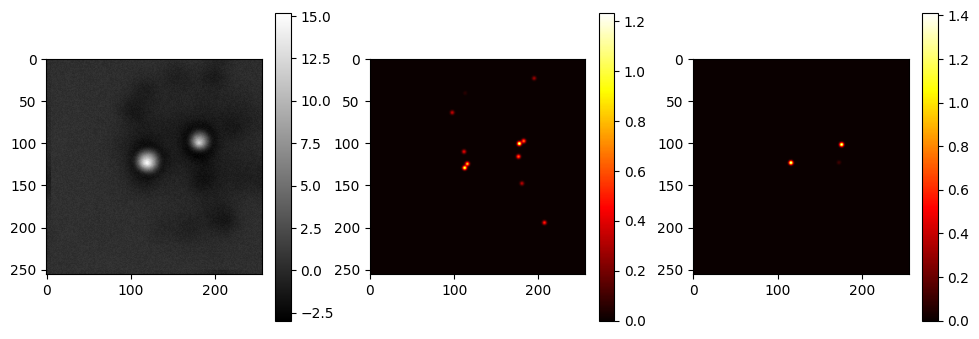

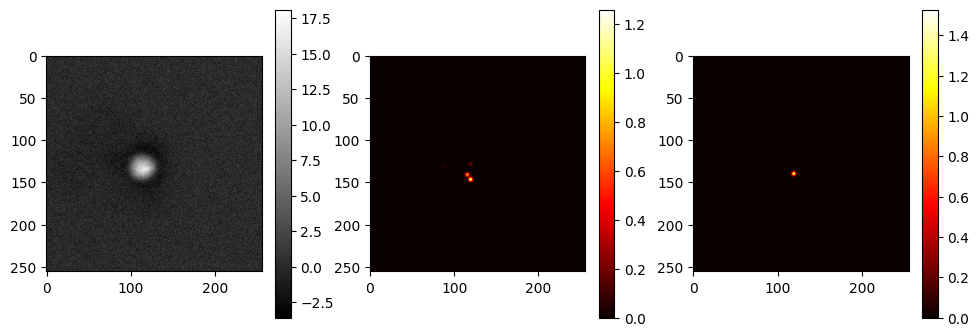

In [9]:
# Plot first batch
x = batch["images"]
y = batch["atom_map"]

num_images = x.shape[0]
num_species = y.shape[-1]
num_heights = y.shape[-2]

for i in range(num_images):
    fig = plt.figure(figsize=(16, 4))
    ax = plt.subplot(141)
    im = ax.imshow(x[i, ..., -5, 0], cmap='gray')
    plt.colorbar(im)

    for j in range(num_species):
        ax = plt.subplot(1, num_species+2, j+2)
        im = ax.imshow(y[i, ..., j].mean(axis=-1), cmap='hot')
        plt.colorbar(im)

    plt.show()
